In [ ]:
# ============================================================================
# Library Installation and Import Check
# ============================================================================
import subprocess
import sys

def install_package(package):
    """Install a package if it's not already installed"""
    try:
        __import__(package)
        print(f"✓ {package} is already installed")
        return True
    except ImportError:
        print(f"⚠ {package} not found. Installing...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
            print(f"✓ {package} installed successfully!")
            return True
        except Exception as e:
            print(f"✗ Failed to install {package}: {e}")
            return False

# List of required packages and their import names
required_packages = {
    'pandas': 'pandas',
    'numpy': 'numpy',
    'scikit-learn': 'sklearn',
    'imbalanced-learn': 'imblearn',
    'lightgbm': 'lightgbm',
    'matplotlib': 'matplotlib'
}

print("="*80)
print("CHECKING AND INSTALLING REQUIRED LIBRARIES")
print("="*80)

# Check and install packages
all_installed = True
for pip_name, import_name in required_packages.items():
    if not install_package(import_name):
        all_installed = False

if not all_installed:
    print("\n⚠ Some packages failed to install. Please install them manually.")
    sys.exit(1)

print("\n" + "="*80)
print("IMPORTING LIBRARIES")
print("="*80)

# Import all required libraries
try:
    import pandas as pd
    print("✓ pandas imported successfully")
    
    import numpy as np
    print("✓ numpy imported successfully")
    
    from sklearn.model_selection import train_test_split, StratifiedKFold
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.metrics import f1_score, classification_report
    print("✓ scikit-learn imported successfully")
    
    from imblearn.over_sampling import SMOTE
    print("✓ imbalanced-learn imported successfully")
    
    import lightgbm as lgb
    from lightgbm import early_stopping
    print("✓ lightgbm imported successfully")
    
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch
    print("✓ matplotlib imported successfully")
    
    import warnings
    warnings.filterwarnings('ignore')
    print("✓ warnings configured")
    
    print("\n" + "="*80)
    print("ALL LIBRARIES SUCCESSFULLY IMPORTED!")
    print("="*80)
    print(f"\nLibrary Versions:")
    print(f"  pandas: {pd.__version__}")
    print(f"  numpy: {np.__version__}")
    print(f"  lightgbm: {lgb.__version__}")
    print(f"  scikit-learn: {__import__('sklearn').__version__}")
    
except ImportError as e:
    print(f"\n✗ Error importing libraries: {e}")
    print("Please ensure all packages are installed correctly.")
    sys.exit(1)

In [2]:
# load data
train_df = pd.read_csv('Data/Training_TriGuard.csv')
test_df = pd.read_csv('Data/Testing_TriGuard.csv')
sample_submission = pd.read_csv('Data/sample_submission.csv')


In [3]:
# prepare features from target
target_col = 'subrogation'
id_col = 'claim_number'

# drop rows where target is missing
train_df = train_df.dropna(subset=[target_col])

y = train_df[target_col]
X = train_df.drop(columns=[target_col])
X_test = test_df.copy()

In [4]:
# train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [5]:
#encode categorical columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit-transform on training
X_train_cat = pd.DataFrame(
    encoder.fit_transform(X_train[cat_cols]),
    columns=encoder.get_feature_names_out(cat_cols),
    index=X_train.index
)
X_val_cat = pd.DataFrame(
    encoder.transform(X_val[cat_cols]),
    columns=encoder.get_feature_names_out(cat_cols),
    index=X_val.index
)
X_test_cat = pd.DataFrame(
    encoder.transform(X_test[cat_cols]),
    columns=encoder.get_feature_names_out(cat_cols),
    index=X_test.index
)

# Combine categorical + numeric features
X_train_encoded = pd.concat([X_train[num_cols].reset_index(drop=True),
                             X_train_cat.reset_index(drop=True)], axis=1)
X_val_encoded = pd.concat([X_val[num_cols].reset_index(drop=True),
                           X_val_cat.reset_index(drop=True)], axis=1)
X_test_encoded = pd.concat([X_test[num_cols].reset_index(drop=True),
                            X_test_cat.reset_index(drop=True)], axis=1)



In [6]:
# SMOTE
sm = SMOTE(random_state=42, sampling_strategy=0.5)
X_train_res, y_train_res = sm.fit_resample(X_train_encoded, y_train)
print(f"After SMOTE → Positive class proportion: {y_train_res.mean():.3f}")



After SMOTE → Positive class proportion: 0.333


In [7]:
# Cross validate LIGHTGBM
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
val_preds_cv = np.zeros(len(X_val_encoded))
test_preds_cv = np.zeros(len(X_test_encoded))

# Track F1 scores for each fold
fold_f1_scores = []
fold_numbers = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_res, y_train_res)):
    print(f"\n===== Fold {fold + 1} =====")
    X_tr, X_vl = X_train_res.iloc[train_idx], X_train_res.iloc[val_idx]
    y_tr, y_vl = y_train_res.iloc[train_idx], y_train_res.iloc[val_idx]

    model = lgb.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        colsample_bytree=0.8,
        subsample=0.8,
        random_state=42
    )

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_vl, y_vl)],
        eval_metric='f1',
        callbacks=[early_stopping(stopping_rounds=50, verbose=True)]
    )

    # Get predictions for this fold on validation set
    val_pred_fold = model.predict_proba(X_val_encoded)[:, 1]
    test_pred_fold = model.predict_proba(X_test_encoded)[:, 1]
    
    # Find best threshold for this fold's validation predictions
    thresholds = np.linspace(0.1, 0.9, 50)
    f1_scores_fold = [f1_score(y_val, (val_pred_fold > t).astype(int)) for t in thresholds]
    best_thresh_fold = thresholds[np.argmax(f1_scores_fold)]
    best_f1_fold = max(f1_scores_fold)
    
    # Store F1 score for this fold
    fold_f1_scores.append(best_f1_fold)
    fold_numbers.append(fold + 1)
    
    print(f"Fold {fold + 1} - Best Threshold: {best_thresh_fold:.3f}, F1 Score: {best_f1_fold:.4f}")

    val_preds_cv += val_pred_fold / kf.n_splits
    test_preds_cv += test_pred_fold / kf.n_splits

# Calculate overall F1 score
thresholds_overall = np.linspace(0.1, 0.9, 50)
f1_scores_overall = [f1_score(y_val, (val_preds_cv > t).astype(int)) for t in thresholds_overall]
best_f1_overall = max(f1_scores_overall)
fold_f1_scores.append(best_f1_overall)
fold_numbers.append('Overall')

print(f"\n===== Summary =====")
print(f"Individual Fold F1 Scores: {[f'{f:.4f}' for f in fold_f1_scores[:-1]]}")
print(f"Overall F1 Score: {best_f1_overall:.4f}")




===== Fold 1 =====
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4443, number of negative: 8885
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12563
[LightGBM] [Info] Number of data points in the train set: 13328, number of used features: 448
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333358 -> initscore=-0.693035
[LightGBM] [Info] Start training from score -0.693035
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[219]	valid_0's binary_logloss: 0.341841
Fold 1 - Best Threshold: 0.263, F1 Score: 0.5734

===== Fold 2 =====
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44


Best Threshold = 0.263 | F1 = 0.5760


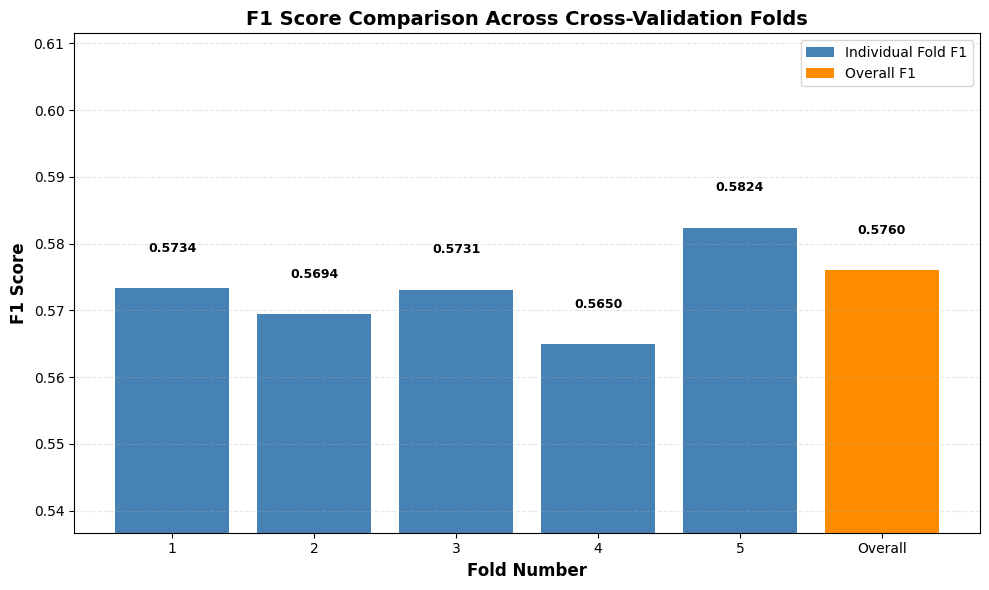


F1 Score Statistics:
  Mean (Folds 1-5): 0.5726
  Std Dev (Folds 1-5): 0.0057
  Min: 0.5650
  Max: 0.5824


In [8]:
#threshold F1
thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = [f1_score(y_val, (val_preds_cv > t).astype(int)) for t in thresholds]
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"\nBest Threshold = {best_thresh:.3f} | F1 = {max(f1_scores):.4f}")

# Create bar chart comparing F1 scores across folds
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(fold_f1_scores)), fold_f1_scores, 
               color=['steelblue'] * (len(fold_f1_scores) - 1) + ['darkorange'])

# Customize the chart
plt.xlabel('Fold Number', fontsize=12, fontweight='bold')
plt.ylabel('F1 Score', fontsize=12, fontweight='bold')
plt.title('F1 Score Comparison Across Cross-Validation Folds', fontsize=14, fontweight='bold')
plt.xticks(range(len(fold_f1_scores)), fold_numbers, fontsize=10)
plt.ylim([min(fold_f1_scores) * 0.95, max(fold_f1_scores) * 1.05])

# Add value labels on bars
for i, (bar, score) in enumerate(zip(bars, fold_f1_scores)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{score:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add legend
legend_elements = [Patch(facecolor='steelblue', label='Individual Fold F1'),
                   Patch(facecolor='darkorange', label='Overall F1')]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nF1 Score Statistics:")
print(f"  Mean (Folds 1-5): {np.mean(fold_f1_scores[:-1]):.4f}")
print(f"  Std Dev (Folds 1-5): {np.std(fold_f1_scores[:-1]):.4f}")
print(f"  Min: {np.min(fold_f1_scores[:-1]):.4f}")
print(f"  Max: {np.max(fold_f1_scores[:-1]):.4f}")



In [9]:
# Final evaluation
val_final = (val_preds_cv > best_thresh).astype(int)
print("\nValidation Results:")
print(classification_report(y_val, val_final, digits=4))




Validation Results:
              precision    recall  f1-score   support

           0     0.9038    0.7649    0.8286      2777
           1     0.4776    0.7254    0.5760       823

    accuracy                         0.7558      3600
   macro avg     0.6907    0.7451    0.7023      3600
weighted avg     0.8064    0.7558    0.7708      3600



In [10]:
#submission
submission = pd.DataFrame({
    id_col: test_df[id_col],
    target_col: (test_preds_cv > best_thresh).astype(int)
})

# Ensure claim_number column exists
if id_col not in submission.columns:
    raise KeyError(f"'{id_col}' column not found in submission!")

submission.to_csv('submission.csv', index=False)
print("\n✅ Submission file created: 'submission.csv'")
print(submission.head())



✅ Submission file created: 'submission.csv'
   claim_number  subrogation
0       3126034            0
1       7380142            1
2       4655051            0
3       6728725            1
4       9848460            1
